<h1>03 Error Estimation for Linear Regression and 3NN</h1>

In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

<h1>Introductory Remarks</h1>
<ul>
    <li>We're going to predict the strength of concrete!</li>
    <li>We have a labeled dataset, originally described in<br />
        I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998).
    </li>
    <li>Nowadays, it is available from the <a href="http://archive.ics.uci.edu/ml/index.php">UC Irvine Machine Learning Repository</a>. I have taken a copy and made it available to you as a CSV file called <code>dataset_concrete.csv</code>.
    </li>
    <li>Use error estimation to compare linear regression and 3NN.
    </li>
 </ul>

In [90]:
df = pd.read_csv('https://raw.githubusercontent.com/bowei-yu/artificial_intelligence/master/ai1/datasets/dataset_concrete.csv')
df

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   fly_ash           1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarse_aggregate  1030 non-null   float64
 6   fine_aggregate    1030 non-null   float64
 7   age               1030 non-null   int64  
 8   strength          1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [106]:
df.describe(include="all")

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [92]:
features = list(df.columns.values)[:-1]
features

['cement',
 'slag',
 'fly_ash',
 'water',
 'superplasticizer',
 'coarse_aggregate',
 'fine_aggregate',
 'age']

In [93]:
X = df[features]
y = df["strength"].values

In [94]:
preprocessor = ColumnTransformer([("scaler", StandardScaler(), features)], remainder="passthrough")
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['cement', 'slag', 'fly_ash', 'water',
                                  'superplasticizer', 'coarse_aggregate',
                                  'fine_aggregate', 'age'])])

In [95]:
linear_regression_model = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LinearRegression())
])
linear_regression_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['cement', 'slag', 'fly_ash',
                                                   'water', 'superplasticizer',
                                                   'coarse_aggregate',
                                                   'fine_aggregate',
                                                   'age'])])),
                ('predictor', LinearRegression())])

In [96]:
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=2)
ss

ShuffleSplit(n_splits=1, random_state=2, test_size=None, train_size=0.8)

In [97]:
# COMPARE
cross_val_score(linear_regression_model, X, y, scoring="neg_mean_absolute_error", cv=10)

array([-14.93975148, -10.67663414,  -8.04819881, -10.90527744,
        -9.37932119,  -9.01508812,  -7.94802107,  -6.60238237,
        -6.41523692,  -6.35957454])

In [98]:
knn_model = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor(n_neighbors=3))
])
knn_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['cement', 'slag', 'fly_ash',
                                                   'water', 'superplasticizer',
                                                   'coarse_aggregate',
                                                   'fine_aggregate',
                                                   'age'])])),
                ('predictor', KNeighborsRegressor(n_neighbors=3))])

In [99]:
# COMPARE
cross_val_score(knn_model, X, y, scoring="neg_mean_absolute_error", cv=10)

array([-12.43210356, -19.18375405,  -7.35372168, -11.14022654,
       -11.05889968,  -5.97087379,  -8.00873786,  -5.9923301 ,
        -4.78815534,  -4.54647249])

In [100]:
# Check if k = 3 is indeed the best hyperparameter
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

dev_X = dev_df[features]
test_X = test_df[features]

dev_y = dev_df["strength"].values
test_y = test_df["strength"].values

knn_model = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor())
])

param_grid = {"predictor__n_neighbors": [x for x in range(1, 13)]}

ss = ShuffleSplit(n_splits=1, train_size=0.75, random_state=2)

gs = GridSearchCV(knn_model, param_grid, scoring="neg_mean_absolute_error", cv=ss, error_score='raise', refit=True)

gs.fit(dev_X, dev_y)

gs.best_params_, gs.best_score_

# compare this to error from 3NN
mean_absolute_error(test_y, gs.predict(test_X))

6.3460679611650495

In [101]:
# Test whether the models are a good fit
scores = cross_validate(linear_regression_model, dev_X, dev_y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("Linear Training error: ", np.mean(np.abs(scores["train_score"])))
print("Linear Testing error: ", np.mean(np.abs(scores["test_score"])))
# underfitted

Linear Training error:  8.242777637744092
Linear Testing error:  8.35241240723355


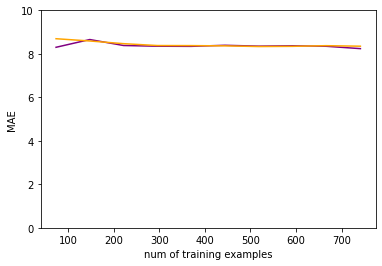

In [102]:
def plot_learning_curve(ymax=10):
  fig = plt.figure()
  plt.xlabel("num of training examples")
  plt.ylabel("MAE")
  plt.ylim(0, ymax)
  plt.plot(train_sizes, mean_maes_train, label="training_error", color = "purple")
  plt.plot(train_sizes, mean_maes_val, label="validation_error", color = "orange")

train_set_sizes = np.linspace(0.1, 1.0, 10)

# plot learning curve:
train_sizes, maes_train, maes_val = learning_curve(linear_regression_model, dev_X, dev_y, train_sizes=train_set_sizes, cv=10, scoring="neg_mean_absolute_error")

mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

plot_learning_curve()
plt.show()

3NN Training error:  5.544064725311101
3NN Testing error:  7.052421921833675


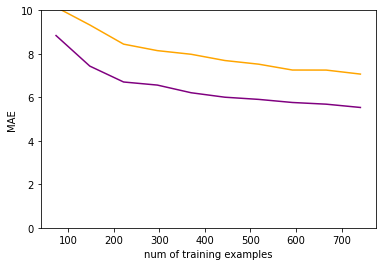

In [103]:
scores = cross_validate(knn_model, dev_X, dev_y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("3NN Training error: ", np.mean(np.abs(scores["train_score"])))
print("3NN Testing error: ", np.mean(np.abs(scores["test_score"])))
# overfitted more

# plot learning curve:
train_sizes, maes_train, maes_val = learning_curve(knn_model, dev_X, dev_y, train_sizes=train_set_sizes, cv=10, scoring="neg_mean_absolute_error")

mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

plot_learning_curve()
plt.show()

KNN Grid Search Training error:  3.986200216528951
KNN Grid Search Testing error:  6.894036501406322


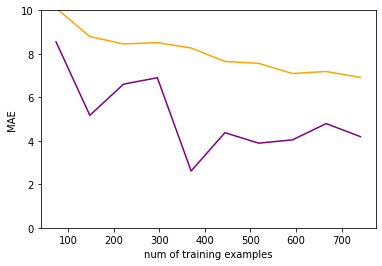

In [104]:
scores = cross_validate(gs, dev_X, dev_y, cv=10, scoring="neg_mean_absolute_error", return_train_score=True)
print("KNN Grid Search Training error: ", np.mean(np.abs(scores["train_score"])))
print("KNN Grid Search Testing error: ", np.mean(np.abs(scores["test_score"])))
# overfitted less

# plot learning curve:
train_sizes, maes_train, maes_val = learning_curve(gs, dev_X, dev_y, train_sizes=train_set_sizes, cv=10, scoring="neg_mean_absolute_error")

mean_maes_train = np.mean(np.abs(maes_train), axis=1)
mean_maes_val = np.mean(np.abs(maes_val), axis=1)

plot_learning_curve()
plt.show()

cement green


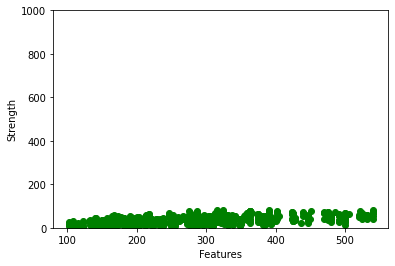

slag yellow


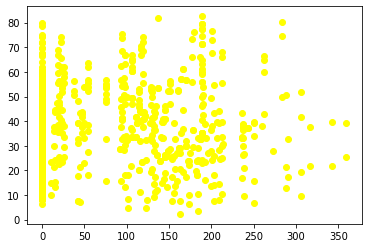

fly_ash red


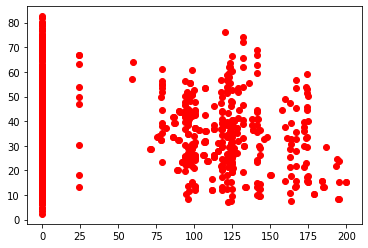

water black


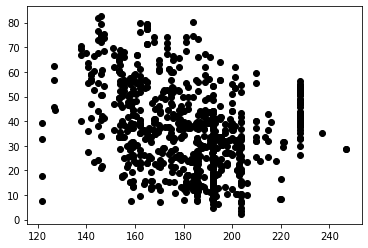

superplasticizer purple


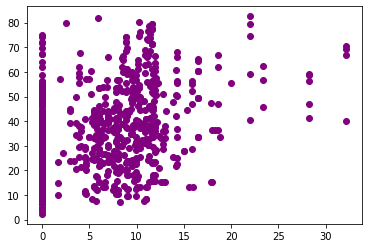

coarse_aggregate orange


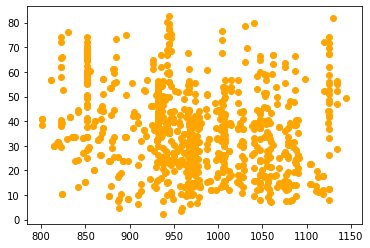

fine_aggregate blue


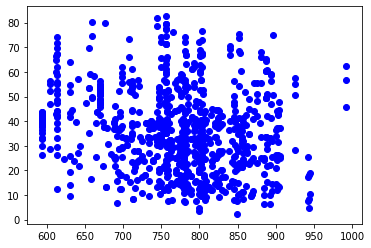

age brown


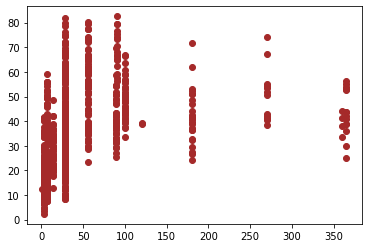

In [107]:
def scatter_plot(feature, color):
  plt.scatter(dev_X[feature], dev_y, color=color)

list_of_colors = ["green", "yellow", "red", "black", "purple", "orange", "blue", "brown"]
count = 0

fig = plt.figure()
plt.xlabel("Features")
plt.ylabel("Strength")
plt.ylim(0, 1000)

for feature in df.columns.values[:-1]:
  print(feature, list_of_colors[count])
  scatter_plot(feature, list_of_colors[count])
  count += 1
  plt.show()